# Prediksi Hujan di Denpasar

Praktikum ini menggunakan _dataset_ [Denpasar Weather Data](https://www.kaggle.com/datasets/cornflake15/denpasarbalihistoricalweatherdata?select=openweatherdata-denpasar-1990-2020v0.1.csv) dengan modifikasi. _Dataset_ digunakan untuk melakukan prediksi penarikan kesimpulan kebenaran kondisi hujan pada kondisi tertentu. Hal itu diperoleh dengan meninjau `raining` (diekstrak dari `weather_main`) sebagai target. Fitur yang digunakan adalah sebagai berikut:
- `hour` (diekstrak dari `dt_iso`)
- `temp`
- `temp_min`
- `temp_max`
- `pressure`
- `humidity`
- `wind_speed`
- `wind_deg`

Tujuan praktikum:
1.   Peserta memahami rangkaian proses analitik data menggunakan pendekatan pembelajaran mesin. 
2.   Peserta memahami bahwa proses pengembangan model pembelajaran mesin juga ditentukan dari kualitas data, penanganan data, dan penentuan algoritma serta hiperparameternya; tidak cukup hanya dengan memastikan implementasi algoritma berjalan tanpa kesalahan.
3.   Peserta mampu menginterpretasikan hasil dari evaluasi model dalam proses analitik menggunakan pendekatan pembelajaran mesin.

Praktikum dilaksanakan secara berkelompok. Setiap kelompok terdiri atas 2 mahasiswa. Perhatikan bahwa terdapat berkas yang harus dikumpulkan sebelum waktu praktikum selesai (17 April 2023, pukul 10.59 WIB) dan berkas yang dikumpulkan setelah waktu praktikum selesai (17 April 2023, pukul 23.59 WIB).

# Persiapan Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [6]:
data = pd.read_csv("openweatherdata-denpasar-1990-2020v0.1-simplified.csv")
data

,hour,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,raining
0,0,25.82,25.82,25.82,1010.0,86,1.36,225,True
1,1,26.20,26.20,26.20,1011.0,84,2.09,247,True
2,2,26.45,26.45,26.45,1011.0,84,2.44,262,True
3,3,26.80,26.80,26.80,1011.0,82,2.29,271,True
4,4,27.04,27.04,27.04,1010.0,82,1.71,274,False
...,...,...,...,...,...,...,...,...,...
264919,19,27.00,27.00,27.00,1007.0,94,4.10,300,False
264920,20,27.00,27.00,27.00,1007.0,94,5.70,300,False
264921,21,28.00,28.00,28.00,1007.0,83,6.70,290,False
264922,22,28.00,28.00,28.00,1007.0,83,6.20,290,False


In [7]:
X = data.drop(columns="raining")
y = data["raining"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Soal

Disediakan data yang sudah dibagi menjadi data latih (`df_train`), data validasi (`df_val`), dan data uji (`df_test`).

**Bagian 1**: (batas waktu: 17 April 2023, 10.59 WIB)

1. Buatlah _baseline_ dengan menggunakan model _logistic regression_.
2. Lakukan analisis data terkait hal berikut:
    - _duplicate value_,
    - _missing value_,
    - _outlier_,
    - _balance of data_.
3. Jelaskan rencana penanganan yang ada pada poin 2.
4. Jelaskan teknik _encoding_ yang digunakan terhadap data yang disediakan, disertai dengan alasan.
5. Buatlah desain eksperimen dengan menentukan hal berikut:
    - tujuan eksperimen,
    - variabel dependen dan independen,
    - strategi eksperimen,
    - skema validasi.
    
**Bagian 2**: (batas waktu: 17 April 2023, 23.59 WIB)

6. Implementasikan strategi eksperimen dan skema validasi yang telah ditentukan pada poin 5.
7. Berdasarkan hasil prediksi yang dihasilkan, buatlah kesimpulan analisis karakteristik kondisi hujan.

---

Jika terdapat perubahan jawaban pada poin 1—5 (contoh: perbedaan penanganan _outlier_), jelaskan pada laporan mengenai jawaban sebelum, jawaban sesudah, dan alasan pengubahan jawaban.

In [8]:
data.describe()

,hour,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg
count,264924.000000,264924.000000,264924.000000,264924.000000,264924.000000,264924.000000,264924.000000,264924.000000
mean,11.516861,27.273336,27.147962,27.397479,1010.032919,80.844997,3.612394,158.204696
std,6.921676,1.962571,1.973218,1.989172,2.286581,8.720109,1.909580,85.000051
min,0.000000,3.000000,2.000000,3.000000,998.400000,14.000000,0.010000,0.000000
25%,6.000000,25.940000,25.820000,26.000000,1008.400000,74.000000,2.100000,106.000000
50%,12.000000,27.000000,27.000000,27.000000,1010.200000,83.000000,3.600000,120.000000
75%,18.000000,28.600000,28.400000,29.000000,1011.900000,88.000000,4.710000,250.000000
max,23.000000,39.000000,39.000000,39.800000,1023.200000,100.000000,31.900000,360.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hour        264924 non-null  int64  
 1   temp        264924 non-null  float64
 2   temp_min    264924 non-null  float64
 3   temp_max    264924 non-null  float64
 4   pressure    264924 non-null  float64
 5   humidity    264924 non-null  int64  
 6   wind_speed  264924 non-null  float64
 7   wind_deg    264924 non-null  int64  
 8   raining     264924 non-null  bool   
dtypes: bool(1), float64(5), int64(3)
memory usage: 16.4 MB


# Bagian 1

In [10]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_pred, y_val)}")
print(f"F1 Score: {f1_score(y_pred, y_val)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_pred, y_val)}")

Accuracy: 0.8736198924223837
F1 Score: 0.22057325767495994
Confusion Matrix:
[[36273  4839]
 [  518   758]]


In [11]:
## Duplicate Value
duplicateData = data[data.duplicated()]
print("Banyak data yang duplikat: ", len(duplicateData))
print()

## Missing Value
number_of_missing_value = data.isnull().sum()
print(f"Missing Value:\n{number_of_missing_value}")
print()

## Balance of Data
unique_values, unique_count = np.unique(y, return_counts=True)
print(pd.DataFrame({"Values": unique_values, "Count": unique_count}))
print()

## Outlier
for col in data.columns:
    if data[col].dtype == "int64" or data[col].dtype == "float64":
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        inside_range = len(data[(data[col] >= lower_bound) & (data[col] <= upper_bound)])
        outside_range = len(data[(data[col] < lower_bound) | (data[col] > upper_bound)])

        print(f"Fitur {col} memiliki batas bawah {lower_bound} dan batas atas {upper_bound}")
        print(f"Fitur {col} memiliki jumlah {inside_range} di dalam outlier dan jumlah {outside_range} di luar outlier")

Banyak data yang duplikat:  7253

Missing Value:
hour          0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
raining       0
dtype: int64

   Values   Count
0   False  230023
1    True   34901

Fitur hour memiliki batas bawah -12.0 dan batas atas 36.0
Fitur hour memiliki jumlah 264924 di dalam outlier dan jumlah 0 di luar outlier
Fitur temp memiliki batas bawah 21.950000000000003 dan batas atas 32.59
Fitur temp memiliki jumlah 263466 di dalam outlier dan jumlah 1458 di luar outlier
Fitur temp_min memiliki batas bawah 21.950000000000003 dan batas atas 32.269999999999996
Fitur temp_min memiliki jumlah 263208 di dalam outlier dan jumlah 1716 di luar outlier
Fitur temp_max memiliki batas bawah 21.5 dan batas atas 33.5
Fitur temp_max memiliki jumlah 264377 di dalam outlier dan jumlah 547 di luar outlier
Fitur pressure memiliki batas bawah 1003.15 dan batas atas 1017.15
Fitur pressure memiliki jumlah 263857 di dalam outlier 

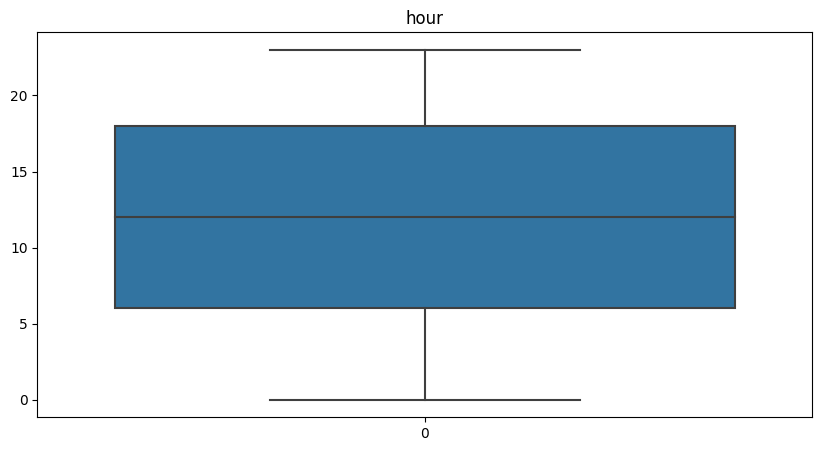

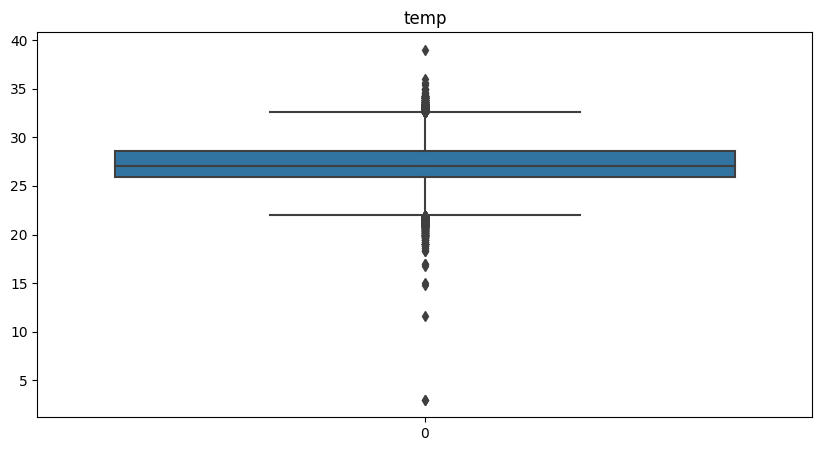

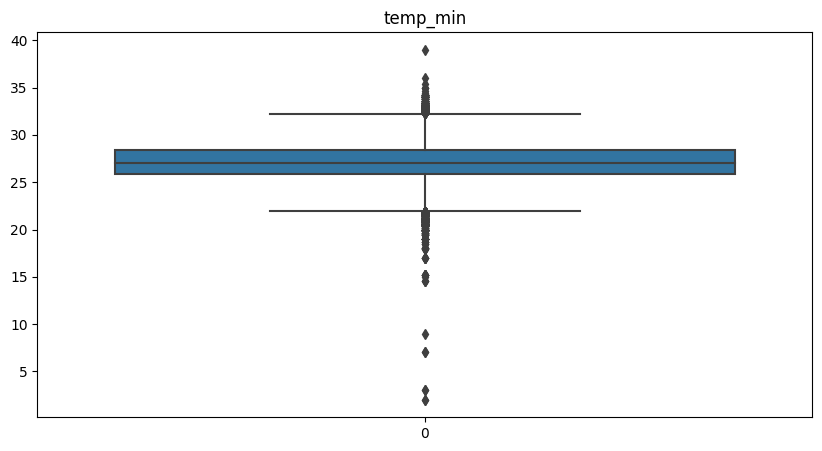

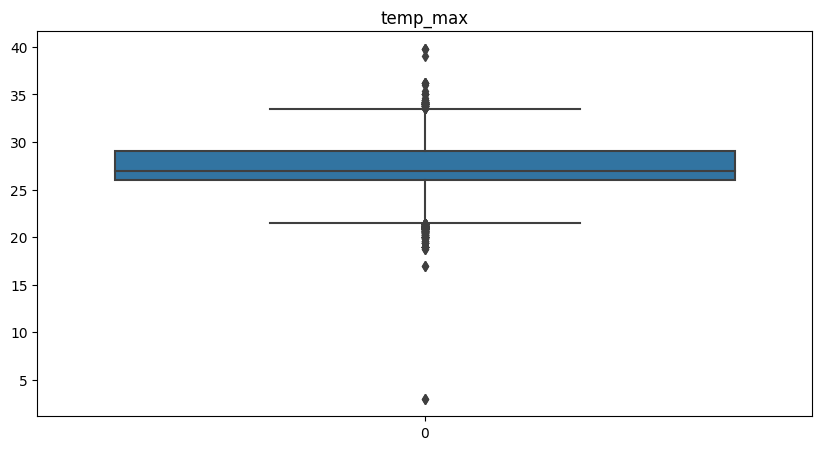

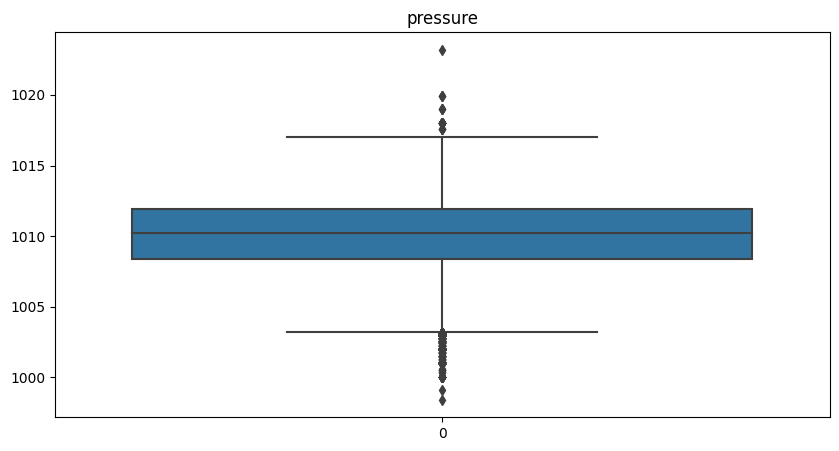

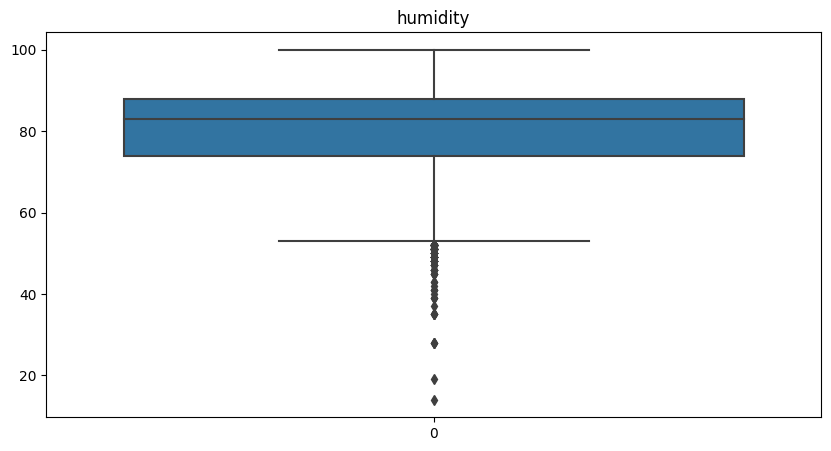

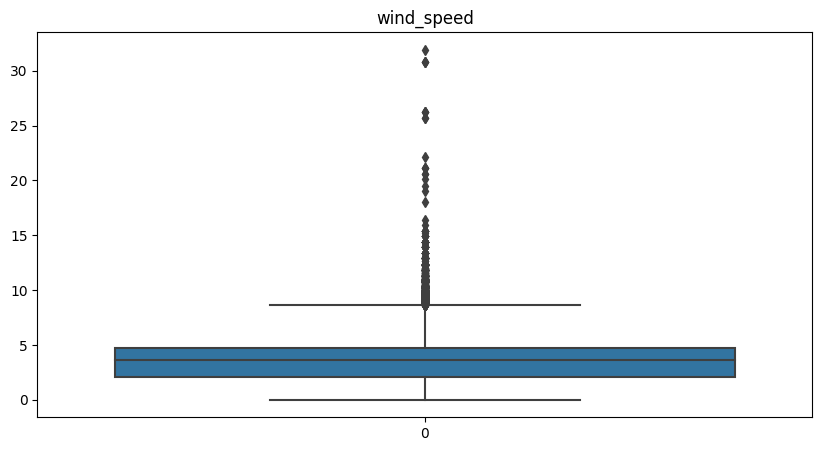

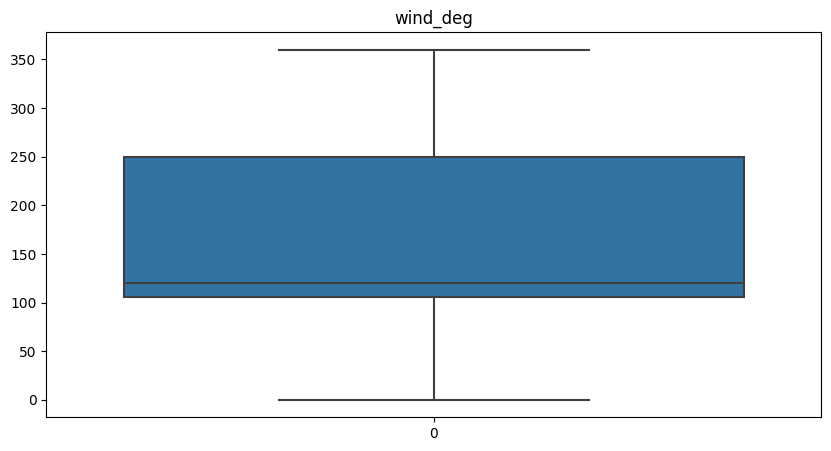

In [12]:
## Grafik Outlier

for col in data.columns:
    if data[col].dtype == "int64" or data[col].dtype == "float64":
        plt.figure(figsize=(10, 5))
        sns.boxplot(data[col])
        plt.title(col)
        plt.show()

## Penanganan Data

- Duplicate Value: Untuk data yang duplikat, akan dilakukan drop pada baris yang duplikat. Hal ini digunakan untuk menghindari bias terhadap data duplikat tersebut.

- Null Value: Untuk data yang null value, akan dilakukan drop terhadap baris yang memiliki kolom bernilai null. Tidak ada data yang null sehingga tidak perlu ada penanganan yang dilakukan.

- Outlier Value: Untuk data yang terletak diluar batas outlier, akan dilakukan drop pada baris yang memiliki kolom bernilai diluar range outlier. Hal ini digunakan untuk mengurangi jumlah iterasi yang diperlukan untuk mencapai keadaan konvergen.

- Balance of Data: Dikarenakan adanya ketidakseimbangan jumlah klasifikasi kelas target, dimana terdapat 230023 nilai "False" dan hanya 34901 nilai "True", maka akan dilakukan Undersampling, Oversampling, dan SMOTE. Kemudian akan dibandingkan nilai F1 Score antara dataset hasil sampling tersebut untuk menentukan metode mana yang menghasilkan performa yang paling baik.

## Encoding

Apabila melihat dari info data, seluruh fitur pada data sudah dalam bentuk numerik, sehingga hanya perlu melakukan encoding pada target. Bila melihat target, nilai yang mungkin adalah antara true atau false. Dari informasi ini, dapat ditarik kesimpulan bahwa encoding yang akan digunakan adalah label encoding. Label encoding adalah suatu metode encoding yang akan memetakan satu nilai kategorikal ke nilai numerik mulai dari 0, 1, dst. 

Label encoding merupakan encoding yang paling simpel dan mudah. Namun, memilikii beberapa kekurangan, salah satunya adalah karena metode ini memberikan nilai yang berurutan (0, 1, 2, ...), secara tidak langsung akan memberikan ordinalitas pada data yang sebenarnya tidak ada maknanya. Hal ini memungkinkan model yang dibuat memberikan bobot yang tidak diinginkan pada angka yang berbeda.

Namun, karena kita hanya melakukan encoding pada target, dimana data tersebut memiliki kardinalitas yang rendah (karena bool bahkan hanya 2), Label encoding yang sifatnya simpel cocok untuk digunakan pada hal ini.

## Desain Eksperimen

Tujuan Eksperimen: Membuat model pembelajaran mesin klasifikasi biner yang dapat mendeteksi apakah suatu satuan waktu (jam) akan terjadi hujan berdasarkan beberapa faktor lingkungan, seperti temperatur, tekanan, kelembapan, kecepatan angin, dan arah datangnya angin.

Variabel Dependen: raining

Variabel Independen: hour, temp, temp_min, temp_max, pressure, humidity, wind_speed, wind_deg

Strategi Eksperimen:

- Pertama - tama, akan dilakukan data preprocessing, dimana seluruh data non-numerik akan di-encode dengan Label Encoder. Kemudian, akan dilakukan data cleaning dengan menghilangkan seluruh baris yang duplikat, memiliki kolom dengan nilai null, atau memiliki kolom dengan nilai yang terletak di luar range outlier. Setelah itu, akan dilakukan teknik Oversampling dan Undersampling terhadap data training dan menentukan metode mana yang menghasilkan performa (F1 Score) yang lebih baik.

- Kedua, akan dilakukan proses lain pada data seperti data scaling pada seluruh fitur dan data encoding pada target

- Lalu, akan dibangun beberapa model, misal akan ada logistic regression. Pembuatan model juga akan dibantu dengan grid search untuk menentukan hyperparameter terbaik. Lalu hyperparameter tersebut akan dimasukkan ke dalam model ensemble untuk melakukan agregat hasil klasifikasi dari beberapa model yang sudah dibuat.

- Terakhir, dilakukan validasi pada model yang dibuat dengan skema validasi yang akan dijelaskan pada bagian berikutnya

Skema Validasi: 

- Eksperimen ini akan menggunakan Train Test Split untuk membagi data menjadi data training dan data validasi. Kemudian, akan dipilih model dengan performa terbaik berdasarkan nilai F1 Score dari seluruh Train Test Split yang telah dilakukan. Kemudian, model tersebut akan dievaluasi dengan menggunakan data testing yang telah dipisah sebelumnya.

Pada sel ini, jelaskan pembagian tugas/kerja per anggota kelompok dalam eksperimen.

# Bagian 2

In [13]:
df = data.copy()

df.head()

,hour,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,raining
0,0,25.82,25.82,25.82,1010.0,86,1.36,225,True
1,1,26.20,26.20,26.20,1011.0,84,2.09,247,True
2,2,26.45,26.45,26.45,1011.0,84,2.44,262,True
3,3,26.80,26.80,26.80,1011.0,82,2.29,271,True
4,4,27.04,27.04,27.04,1010.0,82,1.71,274,False


## Data Cleaning

In [14]:
# Scale menggunakan MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for col in df.columns:
    if df[col].dtype == "int64" or df[col].dtype == "float64":
        df[col] = scaler.fit_transform(df[[col]])

df.head()

,hour,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,raining
0,0.000000,0.633889,0.643784,0.620109,0.467742,0.837209,0.042333,0.625000,True
1,0.043478,0.644444,0.654054,0.630435,0.508065,0.813953,0.065224,0.686111,True
2,0.086957,0.651389,0.660811,0.637228,0.508065,0.813953,0.076199,0.727778,True
3,0.130435,0.661111,0.670270,0.646739,0.508065,0.790698,0.071496,0.752778,True
4,0.173913,0.667778,0.676757,0.653261,0.467742,0.790698,0.053308,0.761111,False


In [15]:
# Drop duplicates

print(f"Before Dropping Duplicate: {df.shape}")

df = df.drop_duplicates()

print(f"After Dropping Duplicate :{df.shape}")


Before Dropping Duplicate: (264924, 9)
After Dropping Duplicate :(257671, 9)


In [16]:
# Drop outlier

print(f"Before Dropping Outlier : {df.shape}")

for col in df.columns:
    if df[col].dtype == "int64" or df[col].dtype == "float64":
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"After Dropping Outlier :{df.shape}")

Before Dropping Outlier : (257671, 9)
After Dropping Outlier :(249087, 9)


In [17]:
# Encode target dengan label encoding

label_encoder = LabelEncoder()
df["raining"] = label_encoder.fit_transform(df["raining"])

df.head()

,hour,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,raining
0,0.000000,0.633889,0.643784,0.620109,0.467742,0.837209,0.042333,0.625000,1
1,0.043478,0.644444,0.654054,0.630435,0.508065,0.813953,0.065224,0.686111,1
2,0.086957,0.651389,0.660811,0.637228,0.508065,0.813953,0.076199,0.727778,1
3,0.130435,0.661111,0.670270,0.646739,0.508065,0.790698,0.071496,0.752778,1
4,0.173913,0.667778,0.676757,0.653261,0.467742,0.790698,0.053308,0.761111,0


In [18]:
# Pisah menjadi training, validation, dan test

X = df.drop(columns="raining")
y = df["raining"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

## Data Sampling

In [19]:
# Undersampling
undersampler = RandomUnderSampler(sampling_strategy="majority", random_state=42)
undersampler_X_train, undersampler_y_train = undersampler.fit_resample(X_train, y_train)

print(f"Jumlah Sampel: {len(undersampler_X_train)}")

undersampler_model = LogisticRegression(max_iter=1000, random_state=42)
undersampler_model.fit(undersampler_X_train, undersampler_y_train)
undersampler_y_pred = undersampler_model.predict(X_test)

print(f"Accuracy: {accuracy_score(undersampler_y_pred, y_test)}")
print(f"F1 Score: {f1_score(undersampler_y_pred, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(undersampler_y_pred, y_test)}")

Jumlah Sampel: 43324
Accuracy: 0.7140993215303706
F1 Score: 0.41552792482252043
Confusion Matrix:
[[30512  1652]
 [12591  5063]]


In [20]:
# Oversampling
oversampler = RandomOverSampler(sampling_strategy="minority", random_state=42)
oversampler_X_train, oversampler_y_train = oversampler.fit_resample(X_train, y_train)

print(f"Jumlah Sampel: {len(oversampler_X_train)}")

oversampler_model = LogisticRegression(max_iter=1000, random_state=42)
oversampler_model.fit(oversampler_X_train, oversampler_y_train)
oversampler_y_pred = oversampler_model.predict(X_test)

print(f"Accuracy: {accuracy_score(oversampler_y_pred, y_test)}")
print(f"F1 Score: {f1_score(oversampler_y_pred, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(oversampler_y_pred, y_test)}")

Jumlah Sampel: 275506
Accuracy: 0.7136376410132884
F1 Score: 0.4145120249528031
Confusion Matrix:
[[30502  1665]
 [12601  5050]]


In [21]:
# SMOTE
smote_sampler = SMOTE(random_state=42)
smote_X_train, smote_y_train = smote_sampler.fit_resample(X_train, y_train)

print(f"Jumlah Sampel: {len(smote_X_train)}")

smote_model = LogisticRegression(max_iter=1000, random_state=42)
smote_model.fit(smote_X_train, smote_y_train)
smote_y_pred = smote_model.predict(X_test)

print(f"Accuracy: {accuracy_score(smote_y_pred, y_test)}")
print(f"F1 Score: {f1_score(smote_y_pred, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(smote_y_pred, y_test)}")

Jumlah Sampel: 275506
Accuracy: 0.7138985908707696
F1 Score: 0.4150695612919112
Confusion Matrix:
[[30508  1658]
 [12595  5057]]


Dikarenakan F1 Score dari SMOTE lebih besar dari Undersampling dan Oversampling, maka training dataset SMOTE yang akan dipilih. Hal ini dikarenakan dataset yang cukup besar yang bertujuan untuk mencegah loss of information.

## Grid Search

In [22]:
# Decision Tree Learning

param_grid = {
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy'],
}

dtl = DecisionTreeClassifier(random_state=42, splitter='best')
grid_search_dtl = GridSearchCV(estimator=dtl, param_grid=param_grid, n_jobs=-1, verbose=2)
grid_search_dtl.fit(smote_X_train, smote_y_train)
grid_search_y_pred = grid_search_dtl.predict(X_test)

print(f"Parameter: {grid_search_dtl.best_params_}") 
print(f"Accuracy: {accuracy_score(grid_search_y_pred, y_test)}")
print(f"F1 Score: {f1_score(grid_search_y_pred, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(grid_search_y_pred, y_test)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................criterion=gini, max_depth=5; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.8s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.8s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.3s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.2s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.3s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.1s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.2s
[CV] END .....................criterion=entropy, max_depth=5; total time=   0.7s
[CV] END .......................criterion=gini, m

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=2)
grid_search_rf.fit(smote_X_train, smote_y_train)
grid_search_y_pred = grid_search_rf.predict(X_test)

print(f"Parameter: {grid_search_rf.best_params_}")
print(f"Accuracy: {accuracy_score(grid_search_y_pred, y_test)}")
print(f"F1 Score: {f1_score(grid_search_y_pred, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(grid_search_y_pred, y_test)}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......criterion=gini, max_depth=5, n_estimators=10; total time=   1.4s
[CV] END .......criterion=gini, max_depth=5, n_estimators=10; total time=   1.4s
[CV] END .......criterion=gini, max_depth=5, n_estimators=10; total time=   1.4s
[CV] END .......criterion=gini, max_depth=5, n_estimators=10; total time=   1.4s
[CV] END .......criterion=gini, max_depth=5, n_estimators=10; total time=   1.4s
[CV] END .......criterion=gini, max_depth=5, n_estimators=20; total time=   2.7s
[CV] END .......criterion=gini, max_depth=5, n_estimators=20; total time=   2.7s
[CV] END .......criterion=gini, max_depth=5, n_estimators=20; total time=   2.9s
[CV] END .......criterion=gini, max_depth=5, n_estimators=20; total time=   2.6s
[CV] END .......criterion=gini, max_depth=5, n_estimators=20; total time=   2.6s
[CV] END .......criterion=gini, max_depth=5, n_estimators=30; total time=   3.9s
[CV] END ......criterion=gini, max_depth=10, n_

In [24]:
# Logistic Regression

param_grid = {
    "solver": ["lbfgs", "liblinear", "newton-cg", "sag", "saga"]
}

log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid, n_jobs=-1, verbose=2)
grid_search_log_reg.fit(smote_X_train, smote_y_train)
grid_search_y_pred = grid_search_log_reg.predict(X_test)

print(f"Parameter: {grid_search_log_reg.best_params_}")
print(f"Accuracy: {accuracy_score(grid_search_y_pred, y_test)}")
print(f"F1 Score: {f1_score(grid_search_y_pred, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(grid_search_y_pred, y_test)}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................solver=liblinear; total time=   0.4s
[CV] END ...................................solver=liblinear; total time=   0.5s
[CV] END ...................................solver=liblinear; total time=   0.5s
[CV] END .......................................solver=lbfgs; total time=   0.7s
[CV] END .......................................solver=lbfgs; total time=   0.7s
[CV] END .......................................solver=lbfgs; total time=   0.9s
[CV] END ...................................solver=liblinear; total time=   0.5s
[CV] END ...................................solver=liblinear; total time=   0.4s
[CV] END .......................................solver=lbfgs; total time=   1.0s
[CV] END .......................................solver=lbfgs; total time=   1.1s
[CV] END ...................................solver=newton-cg; total time=   0.5s
[CV] END ...................................solve

## Model Training

In [25]:
rf_1 = RandomForestClassifier(criterion="gini", max_depth=20, n_estimators=30, random_state=42)
rf_2 = RandomForestClassifier(criterion="gini", max_depth=20, n_estimators=30, random_state=45)
rf_3 = RandomForestClassifier(criterion="gini", max_depth=20, n_estimators=30, random_state=48)
final_estimator = LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)

stacking_ensemble = StackingClassifier(
    estimators=[
        ("rf_1",rf_1),
        ("rf_2", rf_2),
        ("rf_3", rf_3),
    ],
    final_estimator=final_estimator
)
stacking_ensemble.fit(smote_X_train, smote_y_train)
stacking_ensemble_pred = stacking_ensemble.predict(X_val)

print(f"Accuracy: {accuracy_score(stacking_ensemble_pred, y_val)}")
print(f"F1 Score: {f1_score(stacking_ensemble_pred, y_val)}")
print(f"Confusion Matrix:\n{confusion_matrix(stacking_ensemble_pred, y_val)}")

Accuracy: 0.8728609424399056
F1 Score: 0.5718631178707223
Confusion Matrix:
[[31403  2050]
 [ 3017  3384]]


## Model Testing

In [26]:
# Melakukan testing

stacking_ensemble_test = stacking_ensemble.predict(X_test)

print(f"Accuracy: {accuracy_score(stacking_ensemble_test, y_test)}")
print(f"F1 Score: {f1_score(stacking_ensemble_test, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(stacking_ensemble_test, y_test)}")

Accuracy: 0.8725360311533984
F1 Score: 0.5654851512248529
Confusion Matrix:
[[39336  2583]
 [ 3767  4132]]


# _Deliverable_

_Deliverable_ yang akan dihasilkan adalah sebagai berikut:
1. berkas _notebook_ dengan format nama `PraktikumIF3270_M1_NIM1_NIM2.ipynb` untuk Bagian 1;
2. berkas _notebook_ dengan format nama `PraktikumIF3270_M2_NIM1_NIM2.ipynb` untuk Bagian 1 + Bagian 2; serta
3. berkas laporan dengan format nama `PraktikumIF3270_NIM1_NIM2.pdf` yang mencakup hal berikut:
    - hasil analisis data,
    - penanganan dari hasil analisis data,
    - justifikasi teknik-teknik yang dipilih,
    - perubahan yang dilakukan pada jawaban poin 1—5 jika ada,
    - desain eksperimen,
    - hasil eksperimen.
    - analisis dari hasil eksperimen,
    - kesimpulan,
    - pembagian tugas/kerja per anggota kelompok

Batas waktu pengumpulan:
- _Deliverable_ poin 1: Senin, 17 April 2023, pukul 10.59 WIB
- _Deliverable_ poin 2: Senin, 17 April 2023, pukul 23.59 WIB
- _Deliverable_ poin 3: Senin, 17 April 2023, pukul 23.59 WIB

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ef0be974-746b-41b0-82e6-b14f8f7956fc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>